<a href="https://colab.research.google.com/github/rostro36/Partisan-Responses/blob/master/network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Networking
## Pipeline
- Take pair [[[(subject,predicate,object)]],"dem"/"rep"]
- Lemmatize predicate
- subject/object
  - remove stop words
  - take USE
  - search for nearest neighbor
    - if neighbor near enough, use neighbor
    - else create new node
- add edge (subject,object,predicate)
- update weights to party+=1, not_party=not_party

## ToDo
- Fiddling with the correct distance threshold
- Test for small scale
- Do Sentiment Propagation

In [1]:
!pip install hnswlib
#https://github.com/nmslib/hnswlib
import hnswlib
phrase_corpus_length=1
node_index=None
phrase_corpus=[]
import networkx as nx
#https://networkx.github.io/documentation/stable/reference/classes/multigraph.html#methods
MG=nx.MultiDiGraph()
import matplotlib.pyplot as plt
import spacy
sp = spacy.load('en')
import tensorflow_hub as hub
#https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb#scrollTo=W-q2r7jyZGb7


module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [0]:
def lemmatize(phrase):
    return " ".join([word.lemma_ for word in sp(phrase)])

distance_threshold=0.5

def add_node(phrase):
  global phrase_corpus_length
  phrase_corpus_length=phrase_corpus_length+1
  global phrase_corpus
  phrase_corpus.append(phrase)
  if phrase_corpus_length>2:
    global node_index
    del node_index
  node_index=hnswlib.Index('cosine', 512)
  node_index.init_index(phrase_corpus_length, ef_construction = 200, M = 48, random_seed = 36)
  if phrase_corpus_length>2:
    node_index.load_index("node_index",max_elements=phrase_corpus_length)
  node_index.add_items(model([phrase]))
  node_index.save_index("node_index")
  return

def return_node(phrase):
  non_stop_phrase=' '.join([token.text for token in sp(phrase) if not token.is_stop])
  if len(non_stop_phrase)>1:
    phrase=non_stop_phrase
  if node_index is None:
    add_node(phrase)
  nearest_neighbor=node_index.knn_query(model([phrase]))
  if nearest_neighbor!=[]:
    closest_neighbor,closest_distance=nearest_neighbor
  if closest_neighbor[0]==[]:
    add_node(phrase)
    return phrase
  if closest_distance[0][0]>distance_threshold:
    add_node(phrase)
    return phrase
  return phrase_corpus[closest_neighbor[0][0]]

In [0]:
sample=[[[],[('I','like','ice cream')],[('I', 'introducing','the College Opportunity Tax Credit Act of 2009')],[('This legislation','creates','a new tax credit that will put the cost of higher education in reach for American families'),('a new tax credit','put','the cost of higher education')]],'dem']

def other(partisanship):
  if partisanship =='rep':
    return 'dem'
  if partisanship =='dem':
    return 'rep'
  print(partisanship)
  return None

def add_edges(preprocess_output):
  sentences=preprocess_output[0]
  partisanship=preprocess_output[1]
  for sentence in sentences:
    for phrase in sentence:
      subject=return_node(phrase[0])
      objekt=return_node(phrase[2])
      predicate=lemmatize(phrase[1])
      attributes=MG.get_edge_data(subject,objekt,predicate)
      if attributes:
        MG.remove_edge(subject,objekt,predicate)
        weight=attributes['weight']+1
        if partisanship in ('dem','rep'):
          attributes[partisanship]=attributes[partisanship]+1
        dem=attributes['dem']
        rep=attributes['rep']
      else:
        weight=1
        dem=0
        rep=0
        if partisanship=='dem':
          dem=1
        elif partisanship=='rep':
          rep=1
      MG.add_edge(subject,objekt, key=predicate, weight=weight,dem=dem,rep=rep)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Output for an edge that exists: e.g. ('I','ice cream','like')
{'weight': 1, 'dem': 1, 'rep': 0}
Output for an edge that does not exist: e.g. ('I','ice')
None
All edges
[('I', 'ice cream', 'like'), ('I', 'apples', 'like'), ('I', 'College Opportunity Tax Credit Act 2009', 'introduce'), ('College Opportunity Tax Credit Act 2009', 'cost higher education', 'put'), ('legislation', 'College Opportunity Tax Credit Act 2009', 'create')]


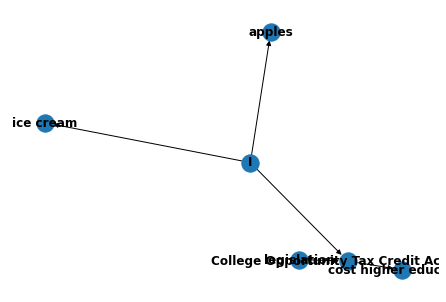

In [4]:
add_edges(sample)
sample=[[[],[('I','like','apples')],[('I', 'introducing','the College Opportunity Tax Credit Act of 2009')],[('This legislation','creates','a new tax credit that will put the cost of higher education in reach for American families'),('a new tax credit','put','the cost of higher education')]],'dem']

add_edges(sample)

nx.draw(MG, with_labels=True, font_weight='bold')
print("Output for an edge that exists: e.g. ('I','ice cream','like')")
print(MG.get_edge_data('I','ice cream','like'))
print("Output for an edge that does not exist: e.g. ('I','ice')")
print(MG.get_edge_data('I','ice'))
print('All edges')
print(MG.edges)